### Загружаем данные

In [299]:
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.metrics import precision_score,recall_score, accuracy_score, f1_score, mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import classification_report

In [300]:
item = 'diamonds' # Выбрать из поля Item для вашего датасета
package = 'ggplot2' # Выбрать из поля Package для вашего датасета

df = sm.datasets.get_rdataset(item, package , cache=True).data
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Для более удобной сортировки категориальных переменных заменим их символьные представления числовыми

In [301]:
cut_dict = {
    'Fair' : 0,
    'Good' : 1,
    'Very Good' : 2,
    'Premium' : 3,
    'Ideal' : 4
}
clarity_dict = {
    'I1' : 1,
    'SI2' : 2,
    'SI1' : 3,
    'VS2' : 4,
    'VS1' : 5,
    'VVS2' : 6,
    'VVS1' : 7,
    'IF' : 8
}

#df['cut_value'] = df['cut'].map(cut_dict)
#df['clarity_value'] = df['clarity'].map(clarity_dict)

### Описание датасета


A data frame with 53940 rows and 10 variables:

price - price in US dollars ($326–$18,823)  
carat - weight of the diamond (0.2–5.01)  
cut - quality of the cut (Fair, Good, Very Good, Premium, Ideal)  
color - diamond colour, from D (best) to J (worst)  
clarity - a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))  
x - length in mm (0–10.74)  
y - width in mm (0–58.9)  
z - depth in mm (0–31.8)  
depth - total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43–79)  
table - width of top of diamond relative to widest point (43–95)

### Задание

1. В рамках промежуточной аттестации 2 вами был проведен разведочный анализ данных и тестирование гипотез для выбранного датасета
2. На основе проведенных наблюдений о взаимосвязи между переменными сформулируйте задачу классификации или регрессии, которая может иметь практическую ценность
3. Разделите датасет на обучающую (60%) и тестовую (40%) выборки. Далее тестовую выборку разделите пополам (20% и 20%):

    а). Первая половина будет использоваться для оценки качества модели. Предполагается, что здесь вы знаете наблюдаемые значения таргета и можете сравнивать их с предсказаниями

    б). Вторая половина будет использоваться для построения прогнозов. Предполагается, что здесь значения таргета вам неизвестны – как в практической ситуации использования моделей прогнозирования.

4. Обучите 3 различные модели, проведите оценку их качества на первой половине
тестовой выборки

5. Для повышения качества можете пользоваться следующими приемами:

    а). Нормализация и стандартизация показателей
  
    б). Подбор гиперпараметров

    в). Включение / исключение дополнительных переменных
    
    г). Трансформация переменных (квадраты, логарифмы и т.п.)

6. Выберите ту модель и набор переменных, которые по вашему мнению дают наиболее удовлетворительное качество.

7. На основе второй половины тестовой выборки сделайте предсказание целевой переменной. На основе предсказаний сделайте рекомендации для потенциальных пользователей вашего анализа

8. Результат сохранить на GitHub и отправить в виде ссылки на файл + блокнота в формате ipynb

Помните, что просто посчитать - это половина задания. К каждому шагу нужны пояснения и описания. Старайтесь структурировать ваш код, чтобы он был понятен стороннему пользователю
Срок – до 25 ноября



### Задача регрессии

Предсказать цену алммаза на основе его характеристик

### Подготовка данных

#### Пропуски

In [302]:
df.isna().count()

carat      53940
cut        53940
color      53940
clarity    53940
depth      53940
table      53940
price      53940
x          53940
y          53940
z          53940
dtype: int64

Пропусков нет.

#### Выбросы

In [303]:
def drop_outliers(df, variable):
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    print(variable, lower_bound, upper_bound)
    return df[(df[variable]>=lower_bound)&(df[variable]<=upper_bound)]

In [304]:
df_clear = df.copy()
df_clear = drop_outliers(df_clear, "carat")
df_clear = drop_outliers(df_clear, "price")

carat -0.5599999999999999 2.0
price -5117.0 11003.0


Сохраним также датафрем с выбросами. Далее попробуем сравнить как они влияют на качество разных моделей.

#### Лишние данные

Удалим из данных колонки описывающие геометрические размеры алмаза. Предполагаем, что их значения сами по себе не вляют на цену, а комбинация их значений уже входит в поле carat.

In [305]:
df.drop(['x', 'y', 'z', 'depth', 'table'], axis=1, inplace=True)
df_clear.drop(['x', 'y', 'z', 'depth', 'table'], axis=1, inplace=True)

In [306]:
df.head()

,carat,cut,color,clarity,price
0,0.23,Ideal,E,SI2,326
1,0.21,Premium,E,SI1,326
2,0.23,Good,E,VS1,327
3,0.29,Premium,I,VS2,334
4,0.31,Good,J,SI2,335


Преобразуем категориальные переменные в двоичные

In [307]:
df = pd.concat([df, pd.get_dummies(df['cut'], dtype=np.uint8, prefix='cut', drop_first=True)], axis=1)
df = pd.concat([df, pd.get_dummies(df['color'], dtype=np.uint8, prefix='color', drop_first=True)], axis=1)
df = pd.concat([df, pd.get_dummies(df['clarity'], dtype=np.uint8, prefix='clarity', drop_first=True)], axis=1)

df_clear = pd.concat([df_clear, pd.get_dummies(df_clear['cut'], dtype=np.uint8, prefix='cut', drop_first=True)], axis=1)
df_clear = pd.concat([df_clear, pd.get_dummies(df_clear['color'], dtype=np.uint8, prefix='color', drop_first=True)], axis=1)
df_clear = pd.concat([df_clear, pd.get_dummies(df_clear['clarity'], dtype=np.uint8, prefix='clarity', drop_first=True)], axis=1)

In [308]:
df

,carat,cut,color,clarity,price,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,Ideal,E,SI2,326,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,0.21,Premium,E,SI1,326,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0.23,Good,E,VS1,327,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0.29,Premium,I,VS2,334,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
4,0.31,Good,J,SI2,335,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,2757,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
53936,0.72,Good,D,SI1,2757,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
53937,0.70,Very Good,D,SI1,2757,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
53938,0.86,Premium,H,SI2,2757,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0


In [309]:
df.drop(['cut', 'color', 'clarity'], axis=1, inplace=True)
df_clear.drop(['cut', 'color', 'clarity'], axis=1, inplace=True)

### Разделение датасета

In [310]:
#x = df[['carat', 'cut', 'color', 'clarity']].values
x = df.drop('price', axis=1).values
y = df[['price']].values
x_clear = df_clear.drop('price', axis=1).values
y_clear = df_clear[['price']].values

In [311]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)
x_test, x_forecast, y_test, y_forecast = train_test_split(x_test, y_test, test_size=0.5, random_state=42)
x_clear_train, x_clear_test, y_clear_train, y_clear_test = train_test_split(x_clear, y_clear, test_size=0.4, random_state=42)
x_clear_test, x_clear_forecast, y_clear_test, y_clear_forecast = train_test_split(x_clear_test, y_clear_test, test_size=0.5, random_state=42)

In [312]:
(
    len(x_train),
    len(x_test),
    len(x_forecast),
)

(32364, 10788, 10788)

In [313]:
(
    len(x_clear_train),
    len(x_clear_test),
    len(x_clear_forecast),
)

(29709, 9903, 9904)

### Постоение моделей

#### Функция оценки моделей регрессии

In [314]:
def regression_metrics(y_test, y_pred):
    
    print('R2', r2_score(y_test, y_pred))
    print('MAE', mean_absolute_error(y_test, y_pred))
    print('RMSE', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('MAPE', mean_absolute_percentage_error(y_test, y_pred))
    
    errors = y_test - y_pred

    fig, ax  = plt.subplots(1,3, figsize = (18,4))

    # График истинных значений против предсказанных
    ax[0].scatter(y_test, y_pred)#, alpha=0.6, color='green')
    ax[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')#, label='Идеальное совпадение')
    ax[0].set_title("График истинных значений против предсказанных")
    ax[0].set_xlabel("Истинные значения (y_test)")
    ax[0].set_ylabel("Предсказанные значения (y_pred)")
    #ax[0].legend()

    # Гистограмма ошибок
    sns.histplot(errors, bins=30, kde=True, ax=ax[1])
    ax[1].axvline(0, color='red', linestyle='--', label='Ноль ошибки')
    ax[1].set_title("Гистограмма ошибок (y_test - y_pred)")
    ax[1].set_xlabel("Ошибка")
    ax[1].set_ylabel("Частота")
    ax[1].legend().remove()

    ax[2].scatter(y_pred, errors)#, alpha=0.6, color='blue')
    ax[2].axhline(0, color='red', linestyle='--', label='Ноль ошибки')
    ax[2].set_title("График остатков против предсказанных значений")
    ax[2].set_xlabel("Предсказанные значения (y_pred)")
    ax[2].set_ylabel("Остатки (y_true - y_pred)")
    
    plt.tight_layout()
    plt.show()

#### Базовая модель

Для сравнения точности будущих моделей линейной регрессии, сформируем оценки простого предсказанием по среднему значению

R2 -1.5947223978463043e-05
MAE 3020.3900630329995
RMSE 3957.3421849634587
MAPE 1.8905748052155995


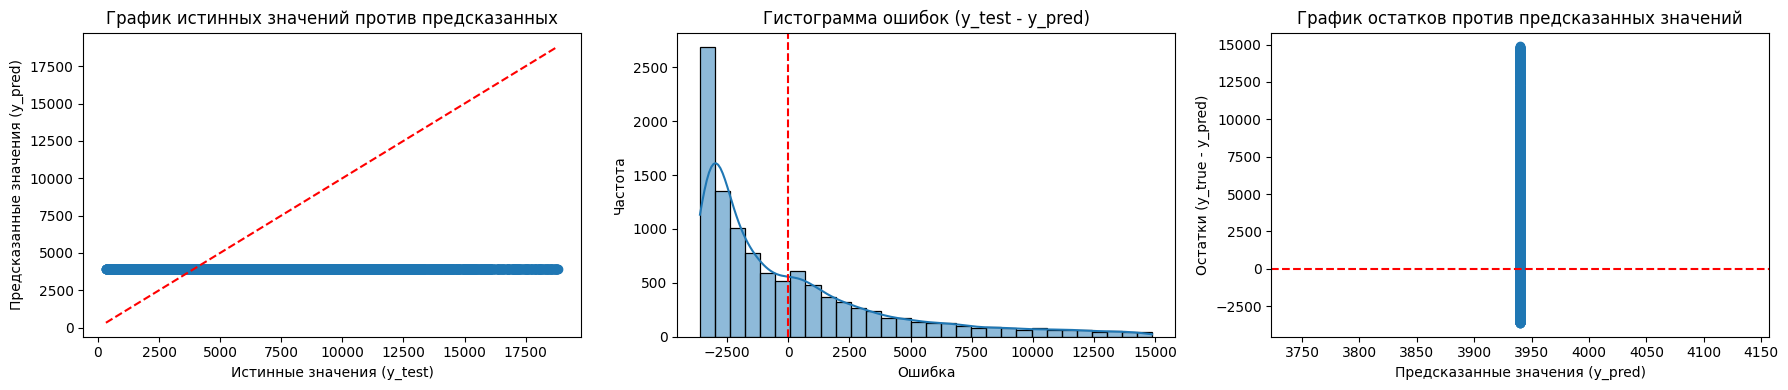

In [315]:
y_pred_mean = np.full_like(y_test, y_train.mean())
regression_metrics(y_test, y_pred_mean)

Как и следовало ожидать, все метрики базовой модели оставляют жедать лучшего. Что говорит о её полной непригодности.

#### LinearRegression

R2 0.9140949631183274
MAE 804.9553610582725
RMSE 1159.8703752541057
MAPE 0.450100437774716


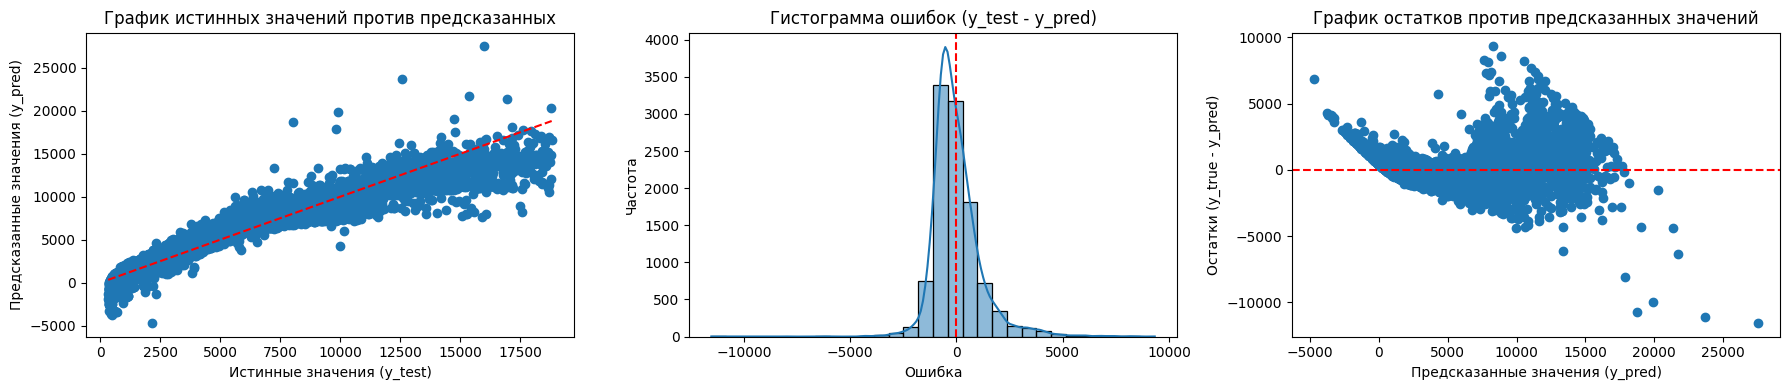

In [316]:
model = LinearRegression()
model.fit(x_train, y_train)
y_pred_lr = model.predict(x_test)
regression_metrics(y_test.flatten(), y_pred_lr.flatten())

Данная модель значительно лучше базовой. Значение R2 = 91.4% говорит о том, что модель хорошо объясняет полученные данные. Но при этом имеет слишком большое среднее отклонение в 45%. Данная модель чувствительна к выбросам. Попробуем без них.

R2 0.9244481907689044
MAE 511.40552158286096
RMSE 705.9048880741559
MAPE 0.31423098001401223


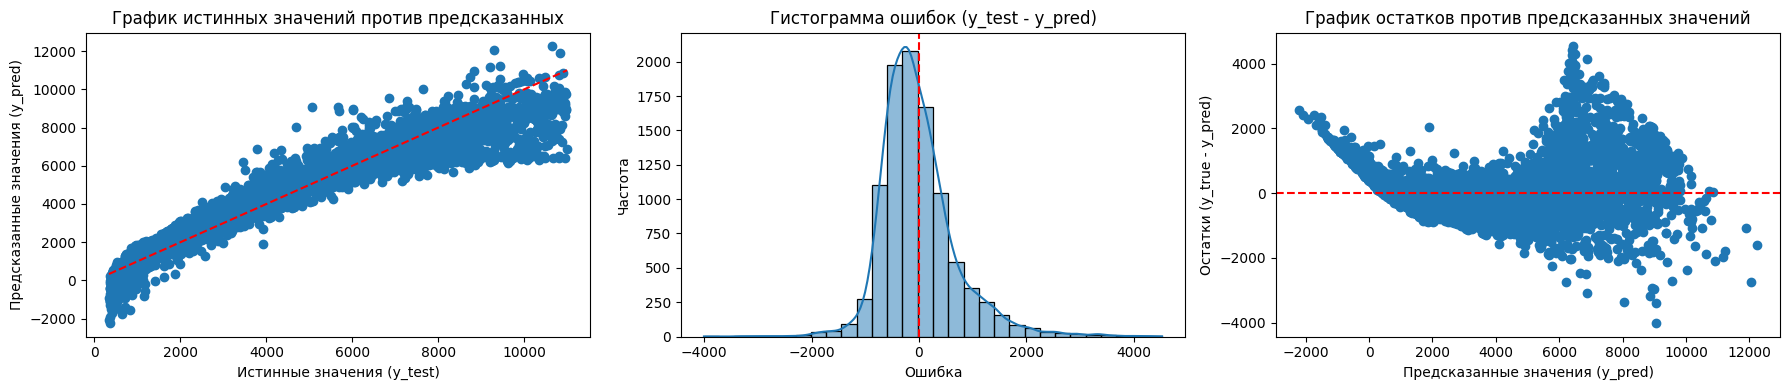

In [317]:
model = LinearRegression()
model.fit(x_clear_train, y_clear_train)
y_pred_clear_lr = model.predict(x_clear_test)
regression_metrics(y_clear_test, y_pred_clear_lr)

Среднее отклонение стало меньше. Качество модели улучшилось.

#### SVR

R2 0.18267757077051305
MAE 1599.8909962863263
RMSE 2321.776779180771
MAPE 0.7275431054944735


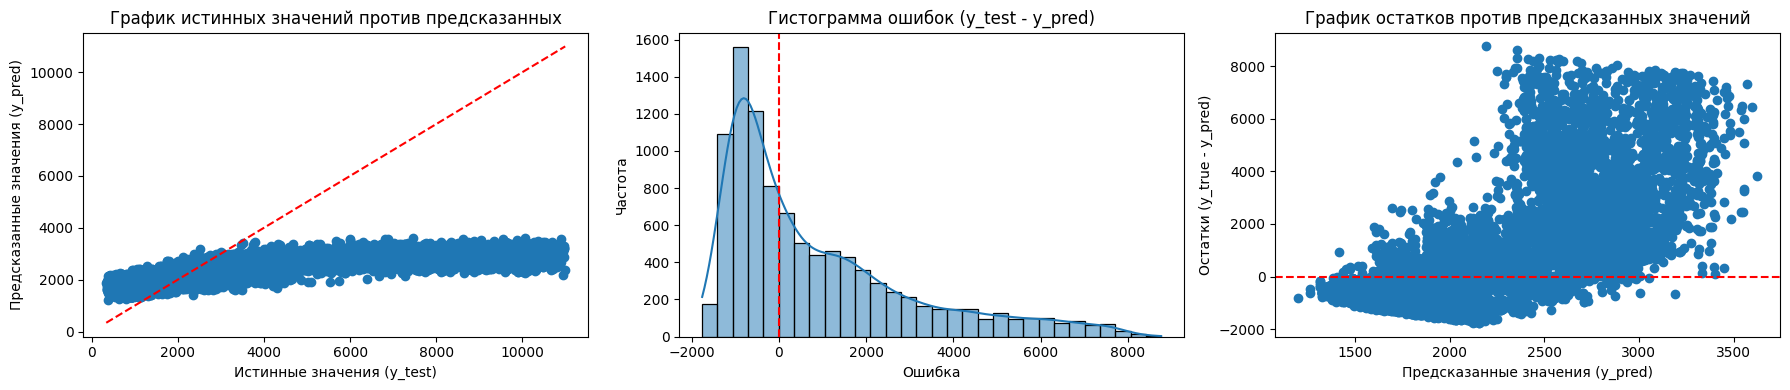

In [318]:
regr_svm = svm.SVR()
regr_svm.fit(x_clear_train, y_clear_train.flatten())
y_pred_svr = regr_svm.predict(x_clear_test)
regression_metrics(y_clear_test.flatten(), y_pred_svr.flatten())

Эта модель не далеко ушла от базовой.

#### SGDRegressor

R2 0.9138700465808308
MAE 802.5354131685618
RMSE 1161.3877687988158
MAPE 0.4446366013509637


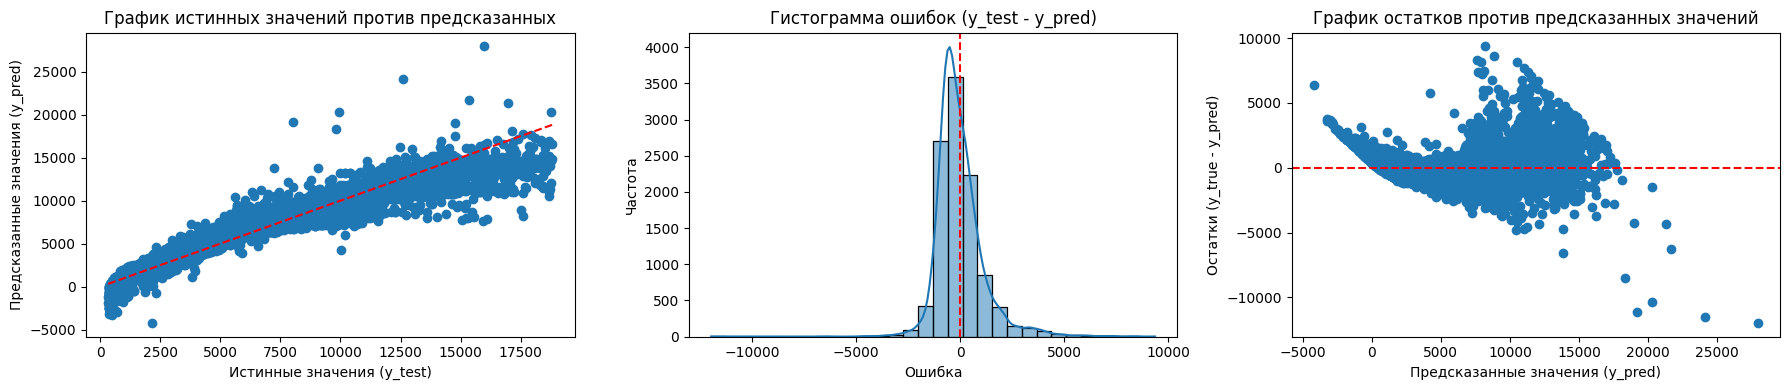

In [319]:
from sklearn.linear_model import SGDRegressor
regr_sgd = SGDRegressor()
regr_sgd.fit(x_train, y_train.flatten())
y_pred_sgd = regr_sgd.predict(x_test)
regression_metrics(y_test.flatten(), y_pred_sgd.flatten())

R2 0.9242815448077408
MAE 508.6887957758456
RMSE 706.6829726967537
MAPE 0.3108311760573723


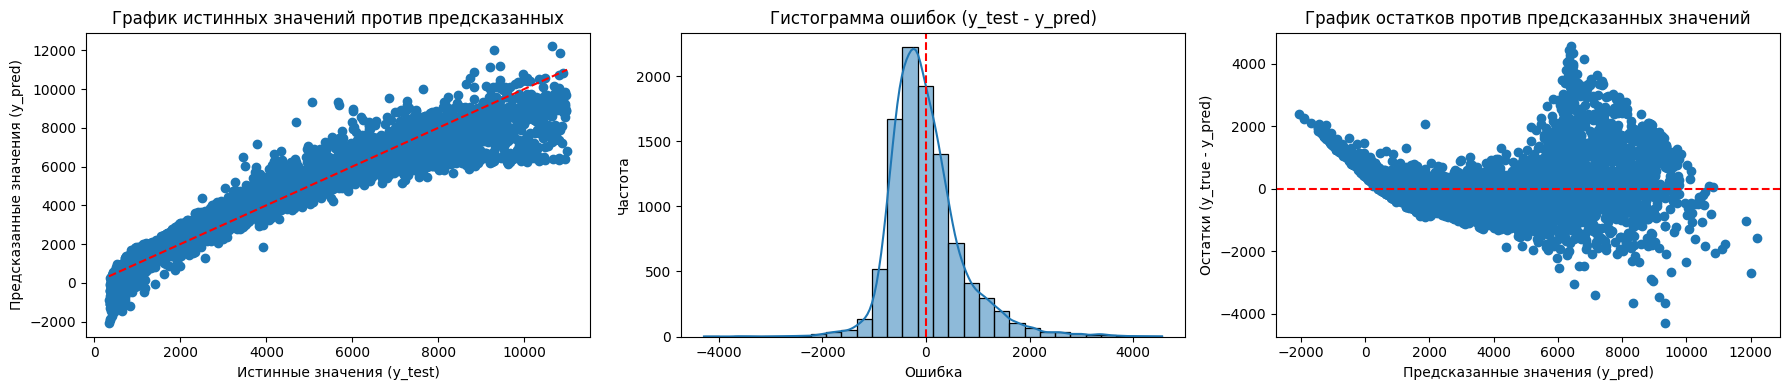

In [320]:
from sklearn.linear_model import SGDRegressor
regr_sgd = SGDRegressor()
regr_sgd.fit(x_clear_train, y_clear_train.flatten())
y_clear_pred_sgd = regr_sgd.predict(x_clear_test)
regression_metrics(y_clear_test.flatten(), y_clear_pred_sgd.flatten())

Показатели примерно такие же, как у линейно регрессии. Никаких приемуществ у этой модели нет.

#### DecisionTreeRegressor

R2 0.9624898432938224
MAE 351.34249687227265
RMSE 766.4336799642335
MAPE 0.09277175363371377


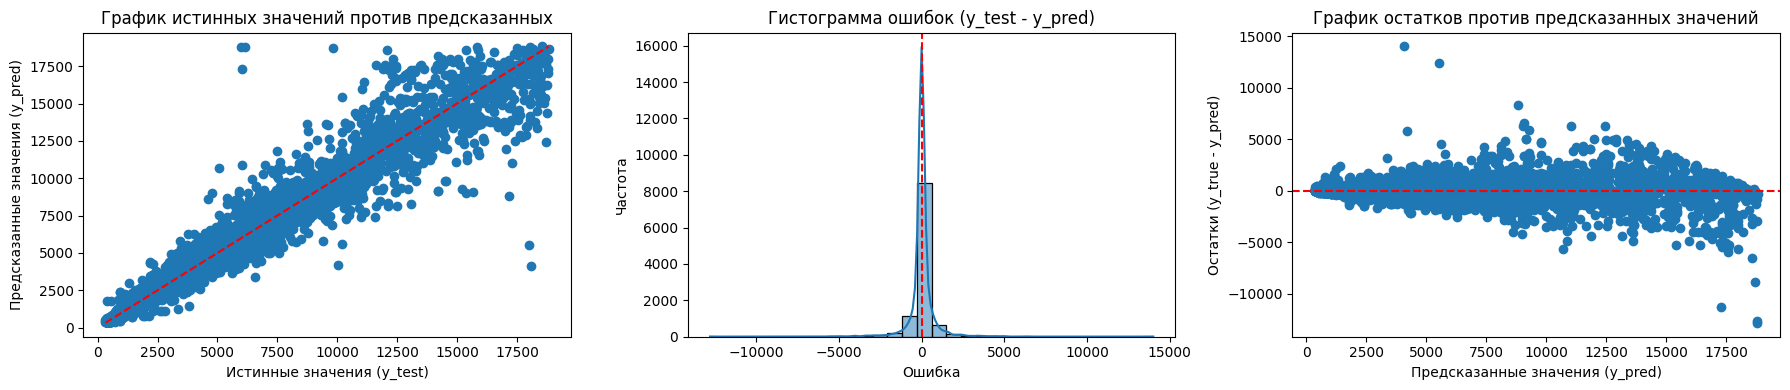

In [321]:
regr_tree = tree.DecisionTreeRegressor()
regr_tree.fit(x_train, y_train.flatten())
y_pred_dt = regr_tree.predict(x_test)
regression_metrics(y_test.flatten(), y_pred_dt.flatten())

R2 0.9685939936469092
MAE 250.34144250011434
RMSE 455.12439213868856
MAPE 0.08970184243268221


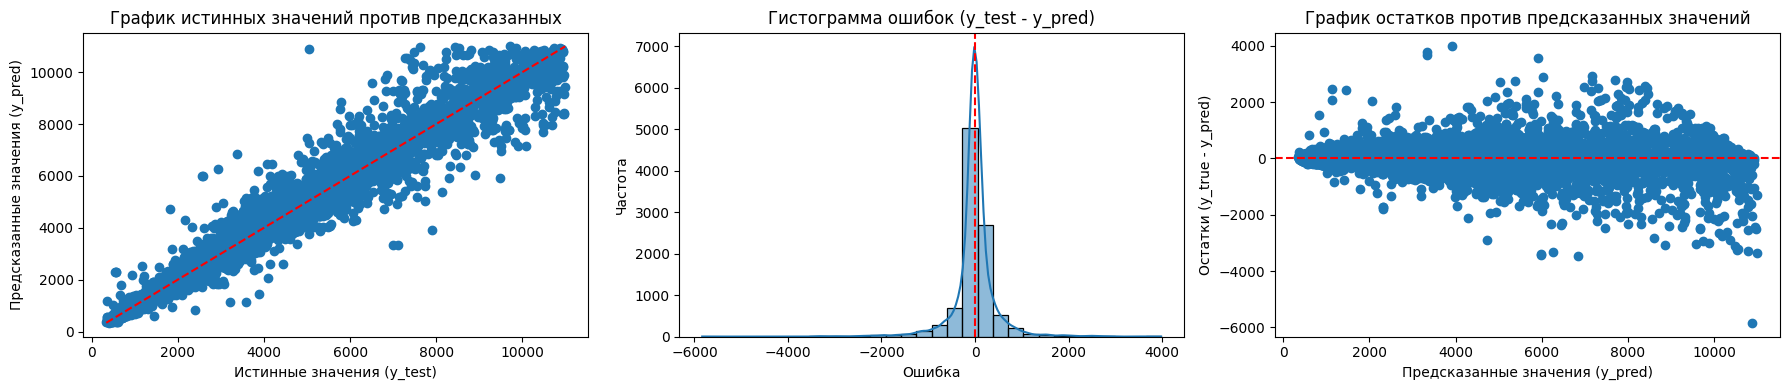

In [322]:
regr_tree = tree.DecisionTreeRegressor()
regr_tree.fit(x_clear_train, y_clear_train.flatten())
y_clear_pred_dt = regr_tree.predict(x_clear_test)
regression_metrics(y_clear_test.flatten(), y_clear_pred_dt.flatten())

Вот это - то, что надо. Эта модель имеет наилучшие показатели из всех протестированных. Попробуем её ещё улучшить.

### Оптимизация модели

Попробуем подобрать гиперпараметры

In [323]:
regr_tree.get_depth()

25

In [324]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(tree.DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search.fit(x_clear_train, y_clear_train.flatten())

print("Лучшие параметры:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Лучшие параметры: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 15}


R2 0.9724340710093335
MAE 241.17970661471563
RMSE 426.39300488947845
MAPE 0.08800240633250132


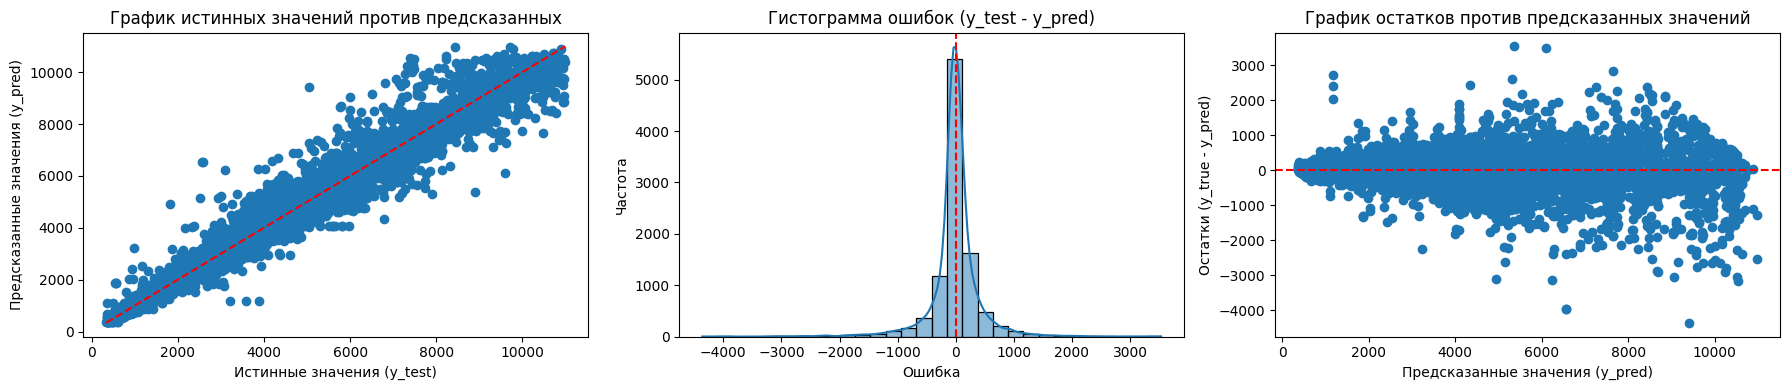

In [325]:
regr_tree = tree.DecisionTreeRegressor(min_samples_leaf=2, min_samples_split=15)
regr_tree.fit(x_clear_train, y_clear_train.flatten())
y_clear_pred_dt = regr_tree.predict(x_clear_test)
regression_metrics(y_clear_test.flatten(), y_clear_pred_dt.flatten())

Подбор параметров позволил немного улучшить качество модели.

### Прогноз

In [326]:
y_clear_forecast = regr_tree.predict(x_clear_forecast)

In [327]:
df_clear.columns

Index(['carat', 'price', 'cut_Good', 'cut_Ideal', 'cut_Premium',
       'cut_Very Good', 'color_E', 'color_F', 'color_G', 'color_H', 'color_I',
       'color_J', 'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1',
       'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2'],
      dtype='object')

Преобразуем массивы обратно в DataFrame

In [328]:
columns = ['carat', 'cut_Good', 'cut_Ideal', 'cut_Premium',
       'cut_Very Good', 'color_E', 'color_F', 'color_G', 'color_H', 'color_I',
       'color_J', 'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1',
       'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2']
x_forecast_df = pd.DataFrame(x_clear_forecast, columns=columns)
y_forecast_df = pd.Series(y_clear_forecast, name='price')

forecast_df = pd.concat([x_forecast_df, y_forecast_df], axis=1)
forecast_df

,carat,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2,price
0,1.22,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5843.625000
1,0.41,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,841.400000
2,0.62,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2202.600000
3,0.50,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1187.428571
4,0.74,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2915.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9899,0.51,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1430.833333
9900,0.52,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1576.200000
9901,0.58,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1427.000000
9902,1.25,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5702.333333


### Выводы

Из описания датасета не понятно какой бизнес-процесс за ним стоит. Тут придётся пофантазировать.

Предположим, что мы занимаемся торговлей алмазами. Тогда при поступлении предложения о покупке алмаза с определенными характеристиками, мы можем быстро определить их рыночную цену для принятия решения о закупке.

Или, если занимаемся производством алмазов, также можем определить рыночную цену готовой продукции.